# Libraries

In [1363]:
import numpy as np
import matplotlib.pyplot as plt
import librosa

# Download Datasets

In [1364]:
from dataset_downloader import DatasetDownloader
dataset_downloader = DatasetDownloader()

#------------------------------------------------
# Remove the commenting below to download the dataset
#------------------------------------------------

#dataset_downloader.download_datasets("datasets/path_files/download_paths_2025.yaml")

# Code

## Short-Time Fourier Transform (STFT)

In [1365]:
#> load audio files
file_path = "datasets/DCASE2025T2/ToyCar/Development/ToyCar/train/section_00_source_train_normal_0001_car_B1_spd_31V_mic_1.wav"
amplitude, sampling_rate = librosa.load(file_path, sr=None, mono=True)

In [1366]:
#> setup of acoustic features
frame_size_time = 0.064 #64ms
frame_size_samples = int(frame_size_time * sampling_rate)
hop_size_samples = frame_size_samples // 2
window_size_samples = frame_size_samples

mel_energies = 128
number_of_frames_to_concatenate = 5

number_of_input_features = mel_energies * number_of_frames_to_concatenate
print("Number of input features: ", number_of_input_features)

Number of input features:  640


In [1367]:
print(f"Sampling Rate:\t{sampling_rate} samples per second")
print(f"Frame Size:\t{frame_size_time} seconds ({frame_size_time * 1000} ms) = {frame_size_samples} samples")
#print(f"Samples per Frame:\t{samples_per_frame}")
#print(f"Hop Size:\t\t{hop_size} samples ({1 / (samples_per_frame / hop_size) * 100} %)")
print(f"Hop Size:\t{hop_size_samples / sampling_rate} seconds ({hop_size_samples / sampling_rate * 1000} ms) =  {hop_size_samples} samples")

Sampling Rate:	16000 samples per second
Frame Size:	0.064 seconds (64.0 ms) = 1024 samples
Hop Size:	0.032 seconds (32.0 ms) =  512 samples


In [1368]:
#> apply stft
stft = librosa.stft(amplitude, n_fft=frame_size_samples, hop_length=hop_size_samples, win_length=window_size_samples)
stft.shape

(513, 376)

### Mel Spectrogram

In [1369]:
mel_spectrogram = librosa.feature.melspectrogram(
    y=amplitude,
    sr=sampling_rate,
    n_fft=frame_size_samples,
    hop_length=hop_size_samples,
    n_mels=mel_energies
)
mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)
mel_spectrogram

array([[-21.359037 , -35.270405 , -33.58871  , ..., -34.853172 ,
        -34.358654 , -18.505054 ],
       [-18.272736 , -22.502966 , -23.040703 , ..., -24.40292  ,
        -21.911257 , -17.48298  ],
       [-12.149305 , -18.131866 , -16.138865 , ..., -16.054533 ,
        -15.990406 , -13.2293005],
       ...,
       [-59.007317 , -59.61678  , -58.09847  , ..., -56.816147 ,
        -56.809288 , -56.884476 ],
       [-60.221134 , -62.160183 , -61.113148 , ..., -57.911407 ,
        -59.06407  , -59.610184 ],
       [-64.69079  , -74.589165 , -77.60099  , ..., -72.74041  ,
        -75.19541  , -74.427025 ]], shape=(128, 376), dtype=float32)

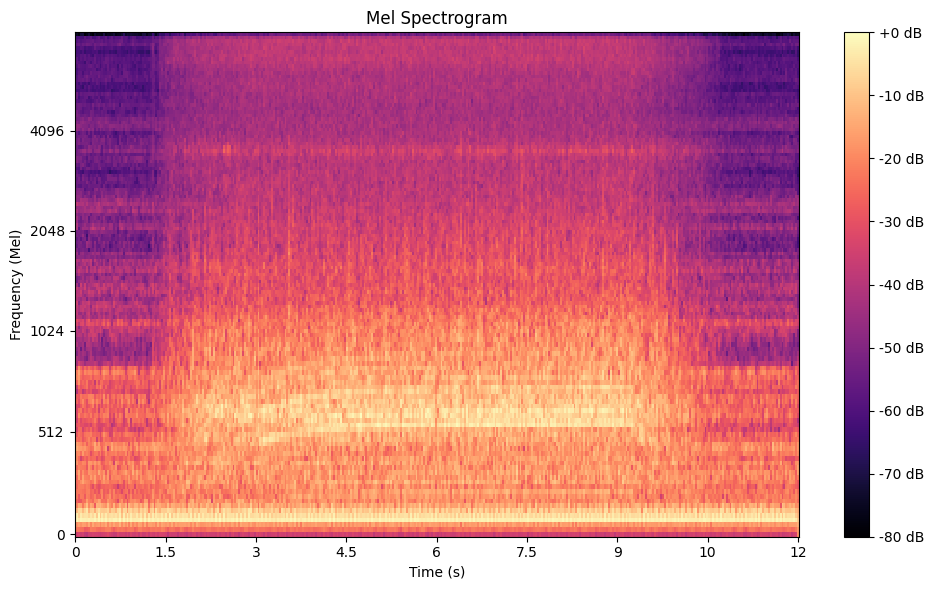

In [1370]:
plt.figure(figsize=(10, 6))
librosa.display.specshow(mel_spectrogram, sr=sampling_rate, hop_length=hop_size_samples, x_axis='time', y_axis='mel', cmap='magma')
plt.colorbar(format='%+2.0f dB')
plt.title("Mel Spectrogram")
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Mel)")
plt.tight_layout()
plt.show()

In [1371]:
number_of_frames = mel_spectrogram.shape[1]

print(f"Number of Mel Energies:\t{mel_energies}")
print(f"Number of Frames:\t{number_of_frames}")

Number of Mel Energies:	128
Number of Frames:	376


In [1372]:
mel_spectrogram.shape

(128, 376)

In [1373]:
input_features = []
for i in range(number_of_frames - number_of_frames_to_concatenate + 1): # 376 - 5 + 1 = 372
    concatenated_segment = mel_spectrogram[:, i:i + number_of_frames_to_concatenate].flatten()
    input_features.append(concatenated_segment)

input_features = np.array(input_features)
input_features.shape

(372, 640)

## Autoencoder

### Preparing Data

In [1374]:
import torch
import torch.nn as nn
import torch.optim as optimizer
from autoencoder import Autoencoder
from torch.utils.data import DataLoader

In [1375]:
input_features.shape

(372, 640)

In [1376]:
input_features

array([[-21.359037, -35.270405, -33.58871 , ..., -77.60099 , -72.16557 ,
        -71.37695 ],
       [-35.270405, -33.58871 , -36.091095, ..., -72.16557 , -71.37695 ,
        -78.55418 ],
       [-33.58871 , -36.091095, -34.99618 , ..., -71.37695 , -78.55418 ,
        -76.142136],
       ...,
       [-35.366028, -34.898754, -33.599792, ..., -71.82839 , -77.051704,
        -72.74041 ],
       [-34.898754, -33.599792, -37.641075, ..., -77.051704, -72.74041 ,
        -75.19541 ],
       [-33.599792, -37.641075, -34.853172, ..., -72.74041 , -75.19541 ,
        -74.427025]], shape=(372, 640), dtype=float32)

In [1377]:
dataset = torch.tensor(input_features, dtype=torch.float32)
train_loader = DataLoader(dataset, batch_size=256, shuffle=True)
dataset.shape

torch.Size([372, 640])

### Setting up Model

In [1378]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Autoencoder().to(device)
criterion = nn.MSELoss()
my_optimizer = optimizer.Adam(model.parameters(), lr=0.001)
number_of_epochs = 10000

### Training

In [1379]:
def train_model():
    #> loop through the number of epochs
    for epoch in range(number_of_epochs):
        model.train() #set the model to training mode
        total_loss = 0 #reset the total loss for this epoch

        #> loop through the training data
        for data in train_loader:
            input = data.to(device) #move the data to the device (GPU or CPU)
            my_optimizer.zero_grad() #reset the gradients of the optimizer

            #> forward pass
            output = model(input) #pass the data through the model
            loss = criterion(output, input) #calculate the loss by comparing the output to the input data

            # print(f"Input vector: {input.cpu().numpy()}")
            # print(f"Input shape: {input.shape}")
            # print(f"Output vector: {output.cpu().detach().numpy()}")
            # print(f"Output shape: {output.shape}")

            #> backward pass
            loss.backward() #compute gradients for all parameters
            my_optimizer.step() #update the model parameters based on the gradients
            total_loss += loss.item() #accumulate the loss for this batch

        average_loss = total_loss / len(train_loader)
        print(f"Epoch [{epoch + 1}/{number_of_epochs}], Loss: {average_loss:.4f}")

    model.eval()
    # with torch.no_grad():
    #     sample = dataset[0].unsqueeze(0).to(device)
    #     reconstruction = model(sample)

    # print("Original:", sample.cpu().numpy())
    # print("Reconstructed:", reconstruction.cpu().numpy())

In [1380]:
train_model()
# output_features = train_model()

Epoch [1/10000], Loss: 1279.9824
Epoch [2/10000], Loss: 1259.2383
Epoch [3/10000], Loss: 1276.0930
Epoch [4/10000], Loss: 1258.1864
Epoch [5/10000], Loss: 1252.8242
Epoch [6/10000], Loss: 1237.9533
Epoch [7/10000], Loss: 1216.8344
Epoch [8/10000], Loss: 1206.8172
Epoch [9/10000], Loss: 1192.7059
Epoch [10/10000], Loss: 1185.3670
Epoch [11/10000], Loss: 1199.1236
Epoch [12/10000], Loss: 1162.7814
Epoch [13/10000], Loss: 1143.8946
Epoch [14/10000], Loss: 1127.8754
Epoch [15/10000], Loss: 1135.1419
Epoch [16/10000], Loss: 1136.2745
Epoch [17/10000], Loss: 1126.6698
Epoch [18/10000], Loss: 1107.2199
Epoch [19/10000], Loss: 1091.4990
Epoch [20/10000], Loss: 1083.6882
Epoch [21/10000], Loss: 1077.3528
Epoch [22/10000], Loss: 1066.8642
Epoch [23/10000], Loss: 1059.3651
Epoch [24/10000], Loss: 1050.5698
Epoch [25/10000], Loss: 1025.0828
Epoch [26/10000], Loss: 1031.1548
Epoch [27/10000], Loss: 1015.9668
Epoch [28/10000], Loss: 1020.7333
Epoch [29/10000], Loss: 988.2735
Epoch [30/10000], Loss: 

In [1381]:
# sample = dataset[0].unsqueeze(0).to(device)
# reconstruction = model(sample).cpu().detach().numpy()

# print("Sample:", sample.cpu().numpy())
# print("Output:", output_features)

In [1382]:
output_features = []

for i in range(input_features.shape[0]):
    row = dataset[i].unsqueeze(0).to(device)
    reconstruction = model(row).cpu().detach().numpy()

    output_features.append(reconstruction)

output_features = np.vstack(output_features)

output_features.shape

(372, 640)

In [1383]:
output_features = output_features.T
output_features.shape

(640, 372)

# Audio Reconstruction

In [1384]:
print(f"Input Shape: {input_features.shape}")
print(f"Input type: {type(input_features)}")
print(f"Output Shape: {output_features.shape}")
print(f"Output type: {type(output_features)}")

Input Shape: (372, 640)
Input type: <class 'numpy.ndarray'>
Output Shape: (640, 372)
Output type: <class 'numpy.ndarray'>


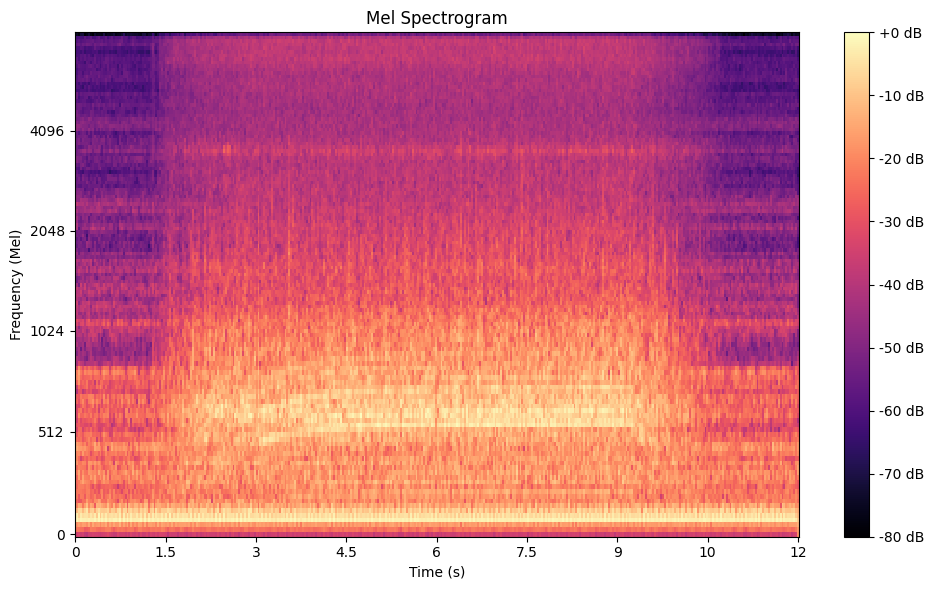

In [1385]:
plt.figure(figsize=(10, 6))
librosa.display.specshow(mel_spectrogram, sr=sampling_rate, hop_length=hop_size_samples, x_axis='time', y_axis='mel', cmap='magma')
plt.colorbar(format='%+2.0f dB')
plt.title("Mel Spectrogram")
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Mel)")
plt.tight_layout()
plt.show()

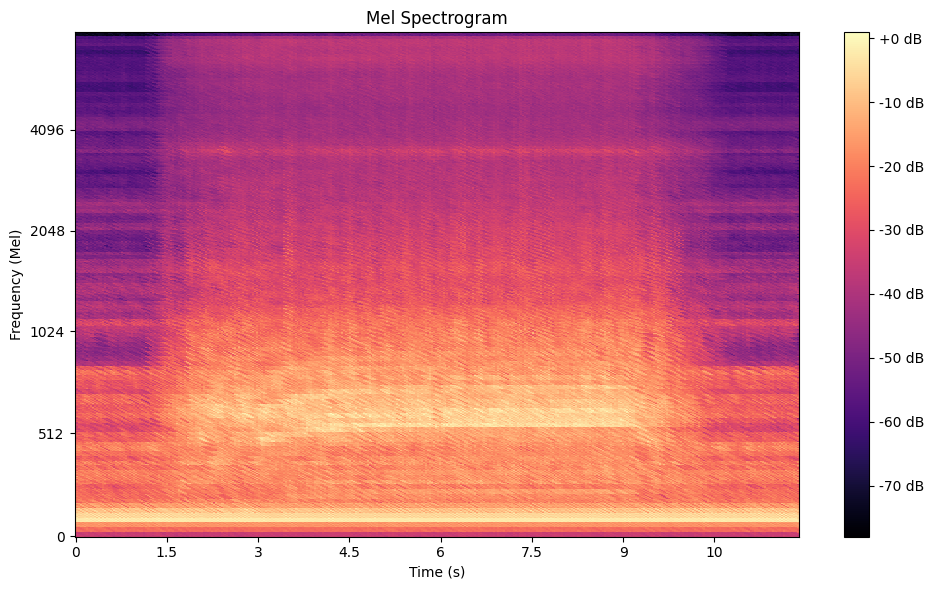

In [1386]:
plt.figure(figsize=(10, 6))
librosa.display.specshow(output_features, sr=sampling_rate, hop_length=hop_size_samples, x_axis='time', y_axis='mel', cmap='magma')
plt.colorbar(format='%+2.0f dB')
plt.title("Mel Spectrogram")
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Mel)")
plt.tight_layout()
plt.show()